<a href="https://colab.research.google.com/github/Sauman9456/Avantari_Technologies_Test-/blob/master/Animal.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install barbar torchsummary

# **Copying and unzipping dataset from Google Drive**

In [ ]:
!cp /content/drive/'My Drive'/Av/* /content/

In [ ]:
!unzip ./dataset.zip

Archive:  ./dataset.zip
   creating: dataset/
  inflating: dataset/3604.jpg        
  inflating: dataset/3487.jpg        
  inflating: dataset/2902.jpg        
  inflating: dataset/1484.jpg        
  inflating: dataset/1175.jpg        
  inflating: dataset/246.jpg         
  inflating: dataset/3618.jpg        
  inflating: dataset/3763.jpg        
  inflating: dataset/2436.jpg        
  inflating: dataset/3248.jpg        
  inflating: dataset/1662.jpg        
  inflating: dataset/4282.jpg        
  inflating: dataset/2351.jpg        
  inflating: dataset/4385.jpg        
  inflating: dataset/2380.jpg        
  inflating: dataset/4651.jpg        
  inflating: dataset/2830.jpg        
  inflating: dataset/1846.jpg        
  inflating: dataset/1807.jpg        
  inflating: dataset/1536.jpg        
  inflating: dataset/2977.jpg        
  inflating: dataset/120.jpg         
  inflating: dataset/1103.jpg        
  inflating: dataset/1985.jpg        
  inflating: dataset/1706.jpg        
  in

# **Importing Libraries**

In [ ]:
import time
import copy
import pickle
from barbar import Bar
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from PIL import Image
import cv2
%matplotlib inline

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from torchsummary import summary

from tqdm import tqdm
from pathlib import Path
import gc
RANDOMSTATE = 0
import os


In [ ]:
# Find if any accelerator is presented, if yes switch device to use CUDA or else use CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


# **Data Loading**

In [ ]:
dataset = Path('/content/dataset/')

In [ ]:
df = pd.DataFrame()

df['image'] = [f for f in os.listdir(dataset) if os.path.isfile(os.path.join(dataset, f))]
df['image'] = '/content/dataset/' + df['image'].astype(str)
df.head(10)

image
0   /content/dataset/473.jpg
1  /content/dataset/1159.jpg
2  /content/dataset/3121.jpg
3  /content/dataset/3844.jpg
4  /content/dataset/2466.jpg
5  /content/dataset/3423.jpg
6  /content/dataset/3691.jpg
7    /content/dataset/82.jpg
8  /content/dataset/3443.jpg
9  /content/dataset/3772.jpg

# **Data Preparation**

In [ ]:
class CBIRDataset(Dataset):
    def __init__(self, dataFrame):
        self.dataFrame = dataFrame
        
        self.transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    def __getitem__(self, key):
        if isinstance(key, slice):
            raise NotImplementedError('slicing is not supported')
        
        row = self.dataFrame.iloc[key]
        image = self.transformations(Image.open(row['image']))
        return image
    
    def __len__(self):
        return len(self.dataFrame.index)

In [ ]:
#Function to process data from the data retrival class
def prepare_data(DF):
    trainDF, validateDF = train_test_split(DF, test_size=0.15, random_state=RANDOMSTATE)
    train_set = CBIRDataset(trainDF)
    validate_set = CBIRDataset(validateDF)
    
    return train_set, validate_set

# **AutoEncoder Model**

In [ ]:
# AutoEncoder Model will take image of size 512*512 and channel = RGB (i.e, 3)
class ConvAutoencoder_v2(nn.Module):
    def __init__(self):
        super(ConvAutoencoder_v2, self).__init__()
        self.encoder = nn.Sequential(# in- (N,3,512,512)
            
            nn.Conv2d(in_channels=3, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=64, 
                      out_channels=64, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1),
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1),
            nn.ReLU(True),
            nn.Conv2d(in_channels=128, 
                      out_channels=128, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=0), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2), 
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=2, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.Conv2d(in_channels=256, 
                      out_channels=256, 
                      kernel_size=(3,3), 
                      stride=1, 
                      padding=1), 
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2) 
        )
        self.decoder = nn.Sequential(
            
            nn.ConvTranspose2d(in_channels = 256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1,
                              padding=1), 
 
            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=256, 
                               kernel_size=(3,3), 
                               stride=1, 
                               padding=1),  
            nn.ReLU(True),

            nn.ConvTranspose2d(in_channels=256, 
                               out_channels=128, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=0),  
            
            nn.ConvTranspose2d(in_channels=128, 
                               out_channels=64, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=64, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1), 
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=32, 
                               kernel_size=(3,3), 
                               stride=2, 
                               padding=1),  
            nn.ReLU(True),
            
            nn.ConvTranspose2d(in_channels=32, 
                               out_channels=3, 
                               kernel_size=(4,4), 
                               stride=2, 
                               padding=2),  
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [ ]:
summary(ConvAutoencoder_v2().to(device),(3,512,512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
              ReLU-2         [-1, 64, 512, 512]               0
            Conv2d-3         [-1, 64, 512, 512]          36,928
              ReLU-4         [-1, 64, 512, 512]               0
         MaxPool2d-5         [-1, 64, 256, 256]               0
            Conv2d-6        [-1, 128, 128, 128]          73,856
              ReLU-7        [-1, 128, 128, 128]               0
            Conv2d-8        [-1, 128, 126, 126]         147,584
              ReLU-9        [-1, 128, 126, 126]               0
        MaxPool2d-10          [-1, 128, 63, 63]               0
           Conv2d-11          [-1, 256, 32, 32]         295,168
             ReLU-12          [-1, 256, 32, 32]               0
           Conv2d-13          [-1, 256, 32, 32]         590,080
             ReLU-14          [-1, 256,

# **Model Training Function with Checkpoint**

In [ ]:
def load_ckpt(checkpoint_fpath, model, optimizer):
    
    # load check point
    checkpoint = torch.load(checkpoint_fpath)

    # initialize state_dict from checkpoint to model
    model.load_state_dict(checkpoint['model_state_dict'])

    # initialize optimizer from checkpoint to optimizer
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

    # return model, optimizer, epoch value, min validation loss 
    return model, optimizer, checkpoint['epoch']

def save_checkpoint(state, filename):
    """Save checkpoint if a new best is achieved"""
    print ("=> Saving a new best")
    torch.save(state, filename)  # save checkpoint
    
def train_model(model,  
                criterion, 
                optimizer, 
                #scheduler, 
                num_epochs):
    since = time.time()
    
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = np.inf

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0

            # Iterate over data.
            for idx,inputs in enumerate(Bar(dataloaders[phase])):
                inputs = inputs.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, inputs)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
           

            epoch_loss = running_loss / dataset_sizes[phase]

            print('{} Loss: {:.4f}'.format(
                phase, epoch_loss))

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                save_checkpoint(state={   
                                    'epoch': epoch,
                                    'state_dict': model.state_dict(),
                                    'best_loss': best_loss,
                                    'optimizer_state_dict':optimizer.state_dict()
                                },filename='ckpt_epoch_{}.pt'.format(epoch))

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, optimizer, epoch_loss

In [ ]:
EPOCHS = 150
NUM_BATCHES = 32
RETRAIN = False

train_set, validate_set = prepare_data(DF=df)

dataloaders = {'train': DataLoader(train_set, batch_size=NUM_BATCHES, shuffle=True, num_workers=1) ,
                'val':DataLoader(validate_set, batch_size=NUM_BATCHES, num_workers=1)
                }

dataset_sizes = {'train': len(train_set),'val':len(validate_set)}

model = ConvAutoencoder_v2().to(device)

criterion = nn.MSELoss()
# Using Adam Adam optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)


In [ ]:
# If re-training is required then loading the model from checkpoint:
# Load the old model
if RETRAIN == True:
    # load the saved checkpoint
    model, optimizer, start_epoch = load_ckpt('../input/cbirpretrained/conv_autoencoder.pt', model, optimizer)
    print('Checkpoint Loaded')

In [ ]:
model, optimizer, loss = train_model(model=model, 
                    criterion=criterion, 
                    optimizer=optimizer, 
                    #scheduler=exp_lr_scheduler,
                    num_epochs=EPOCHS)

In [ ]:
# Save the Trained Model
torch.save({
            'epoch': EPOCHS,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss,
            }, 'conv_autoencoderv2.pt')

#**Image Search**

##**1.Indexing**

In [ ]:
transformations = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])

####**Load Model**

In [ ]:
# Load Model in Evaluation phase
model = ConvAutoencoder_v2().to(device)
model.load_state_dict(torch.load('/content//conv_autoencoderv2.pt', map_location=device)['model_state_dict'], strict=False)

model.eval()

ConvAutoencoder_v2(
  (encoder): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, 

####**Finding Hidden(Latent) features in images**

In [ ]:
def get_latent_features(images, transformations):
    
    #there are 4738 images in data set
    latent_features = np.zeros((4738,256,16,16))
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features[i] = model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy()
        
    del tensor
    gc.collect()
    return latent_features

In [ ]:
images = df.image.values
latent_features = get_latent_features(images, transformations)

100%|██████████| 4738/4738 [01:19<00:00, 59.52it/s]


In [ ]:
indexes = list(range(0, 4738))
feature_dict = dict(zip(indexes,latent_features))
index_dict = {'indexes':indexes,'features':latent_features}

In [ ]:
# write the data dictionary to disk
with open('features.pkl', "wb") as f:
    f.write(pickle.dumps(index_dict))

##**2.Finding Similar Images**

###**Method 1: Euclidean Search**

In [ ]:
def euclidean(a, b):
    # compute and return the euclidean distance between two vectors
    return np.linalg.norm(a - b)
def cosine_distance(a,b):
    #compute and return the cosine_distance
    return scipy.spatial.distance.cosine(a, b)

In [ ]:
def perform_search(queryFeatures, index, maxResults=64):

    results = []

    for i in range(0, len(index["features"])):
        # compute the euclidean distance between our query features
        # and the features for the current image in our index, then
        # update our results list with a 2-tuple consisting of the
        # computed distance and the index of the image
        d = euclidean(queryFeatures, index["features"][i])
        results.append((d, i))
    
    # sort the results and grab the top ones
    results = sorted(results)[:maxResults]
    # return the list of results
    return results

####**Please read the comments carefully for number of images**

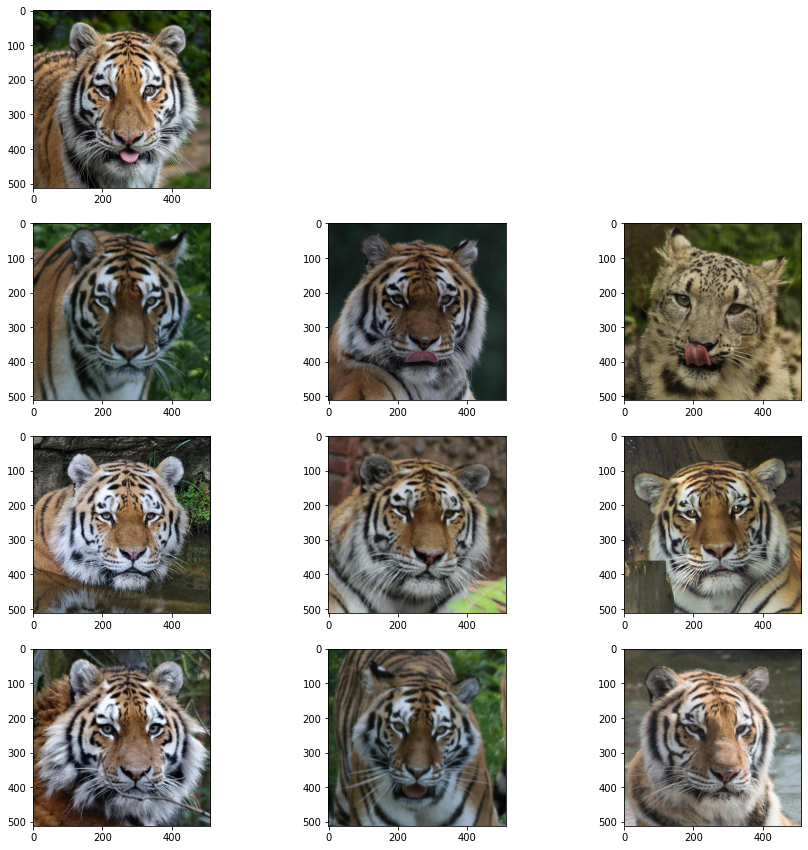

In [ ]:
# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result images
#row & col is number of rows & columns you want in the output default value is 3,3
# Number of images in output = row*col, which is always less than equal to "MAX_RESULTS"
row = 3
col = 3
fig, ax = plt.subplots(nrows=row+1,ncols=col,figsize=(15,15))
queryIdx = 16 # Input Index for which images 
MAX_RESULTS = 25 #Maximum result you want to show default is 64

#Deleting unwanted subplots
for i in range(1,col):
  fig.delaxes(ax[0,i])

queryFeatures = latent_features[queryIdx]
results = perform_search(queryFeatures, index_dict, maxResults=MAX_RESULTS)
imgs = []

# display the query image
ax[0][0].imshow(np.array(Image.open(images[queryIdx])))

# loop over the results
for (d, j) in results:
    img = np.array(Image.open(images[j]))
    imgs.append(img)


temp=0
for m in range(1,row+1):
  for n in range(col):
    temp=temp+1
    ax[m][n].imshow(imgs[temp])


###**Method 2: Locality Sensitive Hashing**

In [ ]:
!pip install lshashpy3
from lshashpy3 import LSHash

In [ ]:
# Locality Sensitive Hashing params
k = 12 # hash size
L = 5  # number of tables
d = 65536 # Dimension of Feature vector
lsh = LSHash(hash_size=k, input_dim=d, num_hashtables=L)

# LSH on all the images
for idx,vec in tqdm(feature_dict.items()):
  lsh.index(vec.flatten(), extra_data=idx)

# Exporting as pickle
pickle.dump(lsh, open('lsh.p', "wb"))

**I'm not completing LSHashing Method because it requires more RAM and Half ram is already used by Euclidean method. So on Colab we can use any one of them at a time else Colab note book will crash. **


In [ ]:
def get_similar_item(idx, feature_dict, lsh_variable, n_items=10):
    response = lsh_variable.query(feature_dict[list(feature_dict.keys())[idx]].flatten(), 
                    num_results=n_items+1, distance_func='hamming')
  
    imgs = []
    for i in range(1, n_items+1):
        imgs.append(np.array(Image.open(images[response[i][0][1]])))
    return imgs

In [ ]:
# take the features for the current image, find all similar
# images in our dataset, and then initialize our list of result images
#row & col is number of rows & columns you want in the output default value is 3,3
# Number of images in output = row*col, which is always less than equal to "MAX_RESULTS"
row = 3
col = 3
fig, ax = plt.subplots(nrows=row+1,ncols=col,figsize=(15,15))
queryIdx = 16 # Input Index for which images 
MAX_RESULTS = 25 #Maximum result you want to show default is 64

#Deleting unwanted subplots
for i in range(1,col):
  fig.delaxes(ax[0,i])



# display the query image
ax[0][0].imshow(np.array(Image.open(images[queryIdx])))

# loop over the results
imgs = get_similar_item(queryIdx, feature_dict, lsh,10)

temp=0
for m in range(1,row+1):
  for n in range(col):
    temp=temp+1
    ax[m][n].imshow(imgs[temp])

# **Bonus point- Clustering of Dataset**

In [ ]:
from sklearn.cluster import KMeans, MiniBatchKMeans
from scipy.spatial.distance import cdist

import matplotlib.cm as cm
%matplotlib inline

In [ ]:
def get_latent_features1D(images, transformations):
    
    latent_features1d = []
    
    for i,image in enumerate(tqdm(images)):
        tensor = transformations(Image.open(image)).to(device)
        latent_features1d.append(model.encoder(tensor.unsqueeze(0)).cpu().detach().numpy().flatten())
        
    del tensor
    gc.collect()
    return latent_features1d

In [ ]:
images = df.image.values
latent_features1d = get_latent_features1D(images, transformations)

100%|██████████| 4738/4738 [01:28<00:00, 53.29it/s]


In [ ]:
latent_features1d = np.array(latent_features1d)
distortions = [] 
inertias = [] 
mapping1 = {} 
mapping2 = {} 
K = range(3,10) 
  
for k in tqdm(K): 
    #Building and fitting the model 
    kmeanModel = KMeans(n_clusters=k).fit(latent_features1d)      
      
    distortions.append(sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_, 
                      'euclidean'),axis=1)) / latent_features1d.shape[0]) 
    inertias.append(kmeanModel.inertia_) 
  
    mapping1[k] = sum(np.min(cdist(latent_features1d, kmeanModel.cluster_centers_, 
                 'euclidean'),axis=1)) / latent_features1d.shape[0] 
    mapping2[k] = kmeanModel.inertia_ 


100%|██████████| 7/7 [52:06<00:00, 446.58s/it]


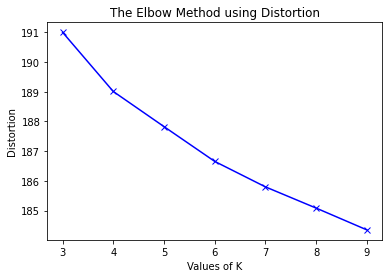

In [ ]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()


###**Using ORB technique**

In [ ]:
def build_dictionary(xfeatures2d, images, n_clusters):
    #print('Computing descriptors..')        
    desc_list = []
    
    for image_path in images:
        image = cv2.imread(image_path)
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        kp, dsc = xfeatures2d.detectAndCompute(gray, None)
        desc_list.extend(dsc)

    desc = np.array(desc_list)
    #print('Creating BoW dictionary using K-Means clustering with k={}..'.format(n_clusters))
    dictionary = MiniBatchKMeans(n_clusters=n_clusters, batch_size=100, verbose=1)
    dictionary.fit(desc)
    
    distortion = sum(np.min(cdist(desc, dictionary.cluster_centers_, 
                      'euclidean'),axis=1)) / desc.shape[0]
    
    return distortion

In [ ]:
orb = cv2.ORB_create()
images = df.image.values
K = range(3,10)
distortions = []

for k in tqdm(K):
    distortions.append(build_dictionary(orb, images, n_clusters=k))


  0%|          | 0/7 [00:00<?, ?it/s]

Init 1/3 with method: k-means++
Inertia for init 1/3: 46677032.379462
Init 2/3 with method: k-means++
Inertia for init 2/3: 45994334.570829
Init 3/3 with method: k-means++
Inertia for init 3/3: 45585572.110326
Minibatch iteration 1/2365300: mean batch inertia: 152137.826039, ewa inertia: 152137.826039 
Minibatch iteration 2/2365300: mean batch inertia: 152648.814753, ewa inertia: 152137.869247 
Minibatch iteration 3/2365300: mean batch inertia: 146134.673638, ewa inertia: 152137.361630 
Minibatch iteration 4/2365300: mean batch inertia: 149975.395047, ewa inertia: 152137.178818 
Minibatch iteration 5/2365300: mean batch inertia: 150204.073419, ewa inertia: 152137.015359 
Minibatch iteration 6/2365300: mean batch inertia: 153809.719790, ewa inertia: 152137.156799 
Minibatch iteration 7/2365300: mean batch inertia: 144922.450444, ewa inertia: 152136.546739 
Minibatch iteration 8/2365300: mean batch inertia: 154094.859861, ewa inertia: 152136.712330 
Minibatch iteration 9/2365300: mean ba


 14%|█▍        | 1/7 [01:17<07:42, 77.05s/it]

Streaming output truncated to the last 5000 lines.
Minibatch iteration 4891/2365300: mean batch inertia: 141214.458207, ewa inertia: 147994.349371 
Minibatch iteration 4892/2365300: mean batch inertia: 140703.622488, ewa inertia: 147993.732883 
Minibatch iteration 4893/2365300: mean batch inertia: 142495.692208, ewa inertia: 147993.267981 
Minibatch iteration 4894/2365300: mean batch inertia: 135768.278263, ewa inertia: 147992.234262 
Minibatch iteration 4895/2365300: mean batch inertia: 142182.459619, ewa inertia: 147991.743000 
Minibatch iteration 4896/2365300: mean batch inertia: 144002.602584, ewa inertia: 147991.405687 
Minibatch iteration 4897/2365300: mean batch inertia: 142526.082801, ewa inertia: 147990.943551 
Minibatch iteration 4898/2365300: mean batch inertia: 143417.718831, ewa inertia: 147990.556849 
Minibatch iteration 4899/2365300: mean batch inertia: 146433.052717, ewa inertia: 147990.425150 
Minibatch iteration 4900/2365300: mean batch inertia: 142511.081244, ewa ine


 29%|██▊       | 2/7 [02:43<06:39, 79.80s/it]

Streaming output truncated to the last 5000 lines.
Minibatch iteration 10511/2365300: mean batch inertia: 141851.688861, ewa inertia: 144701.582425 
Minibatch iteration 10512/2365300: mean batch inertia: 144509.853425, ewa inertia: 144701.566213 
Minibatch iteration 10513/2365300: mean batch inertia: 141100.091032, ewa inertia: 144701.261680 
Minibatch iteration 10514/2365300: mean batch inertia: 143369.635868, ewa inertia: 144701.149080 
Minibatch iteration 10515/2365300: mean batch inertia: 141819.628360, ewa inertia: 144700.905425 
Minibatch iteration 10516/2365300: mean batch inertia: 138449.425652, ewa inertia: 144700.376813 
Minibatch iteration 10517/2365300: mean batch inertia: 141153.817972, ewa inertia: 144700.076924 
Minibatch iteration 10518/2365300: mean batch inertia: 142171.130176, ewa inertia: 144699.863082 
Minibatch iteration 10519/2365300: mean batch inertia: 143598.028609, ewa inertia: 144699.769913 
Minibatch iteration 10520/2365300: mean batch inertia: 140509.87661


 43%|████▎     | 3/7 [04:16<05:35, 83.90s/it]

Streaming output truncated to the last 5000 lines.
Minibatch iteration 8380/2365300: mean batch inertia: 136203.357336, ewa inertia: 141466.629431 
Minibatch iteration 8381/2365300: mean batch inertia: 140589.985815, ewa inertia: 141466.555304 
Minibatch iteration 8382/2365300: mean batch inertia: 135144.634660, ewa inertia: 141466.020736 
Minibatch iteration 8383/2365300: mean batch inertia: 138909.167783, ewa inertia: 141465.804534 
Minibatch iteration 8384/2365300: mean batch inertia: 140169.659076, ewa inertia: 141465.694935 
Minibatch iteration 8385/2365300: mean batch inertia: 136659.094038, ewa inertia: 141465.288499 
Minibatch iteration 8386/2365300: mean batch inertia: 139090.761421, ewa inertia: 141465.087714 
Minibatch iteration 8387/2365300: mean batch inertia: 137016.768364, ewa inertia: 141464.711574 
Minibatch iteration 8388/2365300: mean batch inertia: 137213.534935, ewa inertia: 141464.352104 
Minibatch iteration 8389/2365300: mean batch inertia: 136603.375133, ewa ine


 57%|█████▋    | 4/7 [05:47<04:18, 86.03s/it]

Streaming output truncated to the last 5000 lines.
Minibatch iteration 14905/2365300: mean batch inertia: 136353.985799, ewa inertia: 138933.281755 
Minibatch iteration 14906/2365300: mean batch inertia: 138297.714386, ewa inertia: 138933.228013 
Minibatch iteration 14907/2365300: mean batch inertia: 135310.398516, ewa inertia: 138932.921674 
Minibatch iteration 14908/2365300: mean batch inertia: 138409.078439, ewa inertia: 138932.877379 
Minibatch iteration 14909/2365300: mean batch inertia: 139558.689455, ewa inertia: 138932.930296 
Minibatch iteration 14910/2365300: mean batch inertia: 129354.869886, ewa inertia: 138932.120396 
Minibatch iteration 14911/2365300: mean batch inertia: 135135.253991, ewa inertia: 138931.799341 
Minibatch iteration 14912/2365300: mean batch inertia: 134545.690654, ewa inertia: 138931.428462 
Minibatch iteration 14913/2365300: mean batch inertia: 139753.328850, ewa inertia: 138931.497960 
Minibatch iteration 14914/2365300: mean batch inertia: 134574.88022


 71%|███████▏  | 5/7 [07:28<03:00, 90.36s/it]

Streaming output truncated to the last 5000 lines.
Minibatch iteration 13627/2365300: mean batch inertia: 131189.127785, ewa inertia: 137426.602766 
Minibatch iteration 13628/2365300: mean batch inertia: 139865.023874, ewa inertia: 137426.808953 
Minibatch iteration 13629/2365300: mean batch inertia: 137420.686655, ewa inertia: 137426.808436 
Minibatch iteration 13630/2365300: mean batch inertia: 140530.879330, ewa inertia: 137427.070909 
Minibatch iteration 13631/2365300: mean batch inertia: 135030.512048, ewa inertia: 137426.868261 
Minibatch iteration 13632/2365300: mean batch inertia: 130581.047561, ewa inertia: 137426.289394 
Minibatch iteration 13633/2365300: mean batch inertia: 133420.311717, ewa inertia: 137425.950657 
Minibatch iteration 13634/2365300: mean batch inertia: 135583.512314, ewa inertia: 137425.794864 
Minibatch iteration 13635/2365300: mean batch inertia: 129804.125223, ewa inertia: 137425.150392 
Minibatch iteration 13636/2365300: mean batch inertia: 131203.72642


 86%|████████▌ | 6/7 [09:07<01:33, 93.01s/it]

Streaming output truncated to the last 5000 lines.
Minibatch iteration 16304/2365300: mean batch inertia: 132714.389122, ewa inertia: 134805.994020 
Minibatch iteration 16305/2365300: mean batch inertia: 128707.290566, ewa inertia: 134805.478327 
Minibatch iteration 16306/2365300: mean batch inertia: 132110.455165, ewa inertia: 134805.250442 
Minibatch iteration 16307/2365300: mean batch inertia: 129829.310582, ewa inertia: 134804.829687 
Minibatch iteration 16308/2365300: mean batch inertia: 132690.110539, ewa inertia: 134804.650871 
Minibatch iteration 16309/2365300: mean batch inertia: 131648.851479, ewa inertia: 134804.384023 
Minibatch iteration 16310/2365300: mean batch inertia: 128112.102961, ewa inertia: 134803.818139 
Minibatch iteration 16311/2365300: mean batch inertia: 126188.386461, ewa inertia: 134803.089636 
Minibatch iteration 16312/2365300: mean batch inertia: 131095.004882, ewa inertia: 134802.776089 
Minibatch iteration 16313/2365300: mean batch inertia: 125362.91390


100%|██████████| 7/7 [10:50<00:00, 92.89s/it]


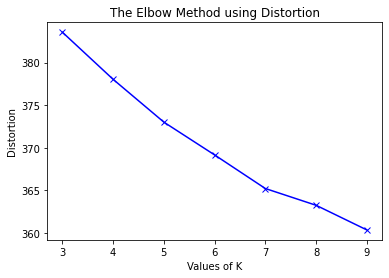

In [ ]:
plt.plot(K, distortions, 'bx-') 
plt.xlabel('Values of K') 
plt.ylabel('Distortion') 
plt.title('The Elbow Method using Distortion') 
plt.show()